In [1]:
# Importing some important libraries
import glob
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA, FactorAnalysis
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import scipy.interpolate as interp
from ipywidgets import *
import pickle as pk
import sncosmo
from sncosmo.salt2utils import BicubicInterpolator
from scipy.interpolate import InterpolatedUnivariateSpline as Spline1d
import math
from tabulate import tabulate
from PTMCMCSampler import PTMCMCSampler
from scipy.integrate import quad

_SCALE_FACTOR = 1e-12

# phase (x) and wavelength (y)
gridx = np.linspace(-8, 48, 48+8+1, dtype=int) # in days
gridy = np.linspace(3500, 8300, int((8300-3500)/10+1), dtype=int) # in Angstroms

# phase (x) and wavelength (y)
gridx_salt2 = np.linspace(-20, 50, 50+20+1, dtype=int) # in days
gridy_salt2 = np.linspace(2000, 9200, 721, dtype=int) # in Angstroms


# Meshhgrid to show a matplotlib graph 
B1, B2 = np.meshgrid(gridx, gridy, indexing='xy')
# (x, y) grid data
xv = []
yv = []
for i in range(0, len(gridy)):
    for j in range(0, len(gridx)):
        xv.append(gridx[j])
        yv.append(gridy[i])
        
# Our pickles paths
pca_path = './PCA_FA_components/PCA/'
fa_path = './PCA_FA_components/FA/'
# Our SEDs path
surfaces_path = './SEDs_matern/'

%matplotlib inline

In [2]:
pickle_pca_path = glob.glob(pca_path+'*.pkl')

In [3]:
np.random.random(42)
if len(pickle_pca_path)>0:
    print('Loading our pca and fa models...')
    pca = pk.load(open(pca_path+'pca.pkl','rb'))
    fa = pk.load(open(fa_path+'fa.pkl','rb'))
    N_comp = 3
else:
    print('Training our model, please wait...')
    # Here, we use glob to know all .dat files names in the befores path
    file_names = glob.glob(surfaces_path+'*.dat')

    # Data & Data erro in a shape of N X x-Length X y-Length
    data = []
    data_err = []
    for i in range(0, len(file_names)):
        surface = pd.read_csv(file_names[i])
        data.append(np.array(surface['flux']))
        data_err.append(np.array(surface['fluxerr']))

    # Training our model using Principal Component Analysis and Factor Analysis
    # Number of components 
    N_comp = 3
    # Defining a PCA instance and fitting
    pca = PCA(N_comp)
    pca.fit(data)
    # Defining a FA instance and fitting
    fa = FactorAnalysis(N_comp)
    fa.fit(data+data_err)
    
    pk.dump(pca, open(pca_path+'pca.pkl','wb'))
    pk.dump(fa, open(fa_path+'fa.pkl','wb'))
    print('Done!')

Loading our pca and fa models...


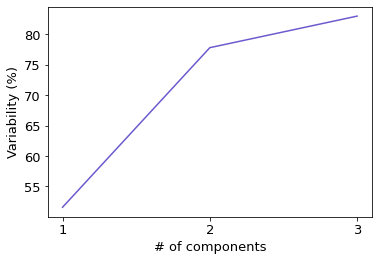

In [4]:
plt.rcParams.update({"font.size": 13})
plt.plot(np.linspace(1, N_comp, N_comp, dtype=int), np.cumsum(pca.explained_variance_ratio_)*100, color="slateblue")
plt.xlabel('# of components')
plt.ylabel('Variability (%)')
plt.xticks(np.linspace(1, N_comp, N_comp, dtype=int))
#plt.axvline(x=3, color='k', linestyle='--', label='EXP(3)')
plt.subplots_adjust(bottom=0.15)
plt.subplots_adjust(left=0.15)
#plt.legend();

In [5]:
print("Explained variance in 3 components: ", pca.explained_variance_ratio_[0]+pca.explained_variance_ratio_[1]+pca.explained_variance_ratio_[2])

Explained variance in 3 components:  0.829614884207448


/tmp/ipykernel_2232/583178012.py:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = axes3d.Axes3D(fig)


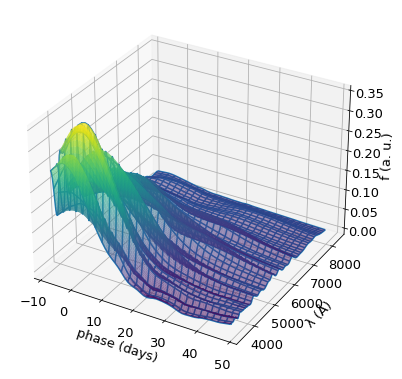

In [6]:
# Mean surface
Z = interp.griddata((xv, yv),pca.mean_,(B1,B2),method='cubic')
fig = plt.figure(figsize=(7, 5))
ax = axes3d.Axes3D(fig)
ax.plot_wireframe(B1, B2, Z)
ax.plot_surface(B1, B2, Z, cmap=cm.viridis, lw=0.5, rstride=1, cstride=1, alpha=0.6)
ax.set_xlabel("phase (days)")
ax.set_ylabel("λ (Å)")
ax.set_zlabel("f (a. u.)")

plt.show()

/tmp/ipykernel_2232/2111624935.py:6: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = axes3d.Axes3D(fig)


interactive(children=(Dropdown(description='Component:', options=(0, 1, 3), value=0), Output()), _dom_classes=…

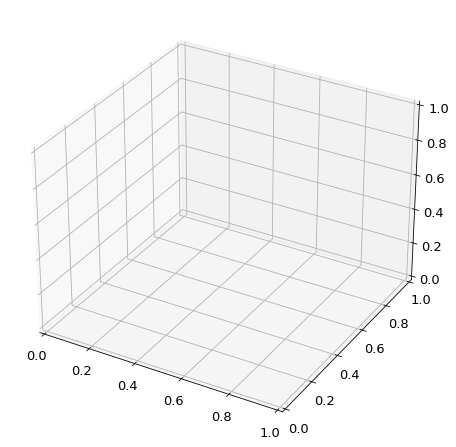

In [7]:
option_list = np.linspace(0, len(fa.components_), len(fa.components_), dtype=int)

#matplotlib notebook

fig = plt.figure(figsize=(10, 6))
ax = axes3d.Axes3D(fig)

def update_graph(i):
    
    ax.clear()
    
    Z = interp.griddata((xv,yv), pca.components_[i], (B1,B2),method='cubic')
    #Z = splinemean(B1, B2)
    ax.plot_wireframe(B1, B2, Z)
    ax.plot_surface(B1, B2, Z, cmap=cm.viridis, lw=0.5, rstride=1, cstride=1, alpha=0.6)
    ax.set_xlabel("phase (days)")
    ax.set_ylabel("λ (Å)")
    ax.set_zlabel("f (a. u.)")
    plt.show()
    
i = widgets.Dropdown(options=option_list, value=0, description='Component:', disabled=False)

widgets.interactive(update_graph,i = i)

In [8]:
M0_salt2 = pd.read_csv("./SALT2_templates/salt2_template_0.dat", names=["time", "wave", "flux"], sep="\s+")
M1_salt2 = pd.read_csv("./SALT2_templates/salt2_template_1.dat", names=["time", "wave", "flux"], sep="\s+")
c = pd.read_csv("./SALT2_templates/salt2_colour_law_guy2010.dat", header = None, sep = "\s+") # color term
c.columns = ["wave", "ext"]
c.head()

wave      ext
0  3000  4.44356
1  3010  4.35652
2  3020  4.27089
3  3030  4.18667
4  3040  4.10384

In [9]:
M = []
for i in range(0, len(fa.components_)):
    M.append(fa.components_[i].reshape(len(gridy), len(gridx)).T*_SCALE_FACTOR)

In [10]:
# A new class for sncosmo
class EXP_LC(sncosmo.Source):
    
    _param_names = ['x0', 'x1', 'x2','x3','x4','x5','x6','x7','x8','x9', 'c']
    param_names_latex = ['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'c']
    
    def __init__(self, phase, wave, flux0, flux1, flux2, flux3, flux4, flux5, flux6, flux7, flux8, flux9, LC, name='EXP', version='2021'):

        self.name = name
        self.version = version
        self._phase = phase
        self._wave = wave
        
        self._model_flux0  = BicubicInterpolator(phase, wave, flux0)
        self._model_flux1  = BicubicInterpolator(phase, wave, flux1)
        self._model_flux2  = BicubicInterpolator(phase, wave, flux2)
        self._model_flux3  = BicubicInterpolator(phase, wave, flux3)
        self._model_flux4  = BicubicInterpolator(phase, wave, flux4)
        self._model_flux5  = BicubicInterpolator(phase, wave, flux5)
        self._model_flux6  = BicubicInterpolator(phase, wave, flux6)
        self._model_flux7  = BicubicInterpolator(phase, wave, flux7)
        self._model_flux8  = BicubicInterpolator(phase, wave, flux8)
        self._model_flux9  = BicubicInterpolator(phase, wave, flux9)
        self._model_ext =  Spline1d(LC['wave'], LC['ext'],  k=1)  

        self._parameters = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])  # initial guess
        
    def _flux(self, phase, wave):
        x0, x1, x2, x3, x4, x5, x6, x7, x8, x9, c = self._parameters
        #print('flux!')
        return x0 * (self._model_flux0(phase, wave) +  x1 * self._model_flux1(phase, wave) +  x2 * self._model_flux2(phase, wave) +  x3 * self._model_flux3(phase, wave) +  x4 * self._model_flux4(phase, wave)  +  x5 * self._model_flux5(phase, wave) +  x6 * self._model_flux6(phase, wave) +  x7 * self._model_flux7(phase, wave) +  x8 * self._model_flux8(phase, wave) +  x9 * self._model_flux9(phase, wave))* 10.** (-0.4 * self._model_ext(wave) * c)

In [11]:
lc_fit_table_exp = glob.glob('./cosmo_results/*exp3.dat')

In [12]:
lc_fit_table_exp

['./cosmo_results/matern_fit_exp3.dat']

In [13]:
table_exp3 = []

In [14]:
outliers = [19, 106, 107]

In [15]:
if len(lc_fit_table_exp) > 0:
    print('Loading our light curve parameters...')
    exp3_fit = pd.read_csv('./cosmo_results/matern_fit_exp3.dat',
                           sep='\s+',
                           names = ['name', 'redshift', 't0', 't0_err', 'x0', 'x0_err', 'x1', 'x1_err', 'x2', 'x2_err', 'mwebv','cov_x0x1', 'cov_x0x2', 'cov_x1x2', 'chiquad/dof', 'model'])
else:
    print('Applying fits to our SNe')
    exp_lc = EXP_LC(gridx, gridy, M[0], M[1], M[2], M[2], M[2], M[2], M[2], M[2], M[2], M[2], c) # change to M[2] to other orders SEDs
    files = glob.glob('./JLA/*.list')
    print("JLA files in path: ", len(files))

    for i in range(0, len(files)):
        print(i)
        if i not in outliers:
            data = sncosmo.read_lc(files[i], format='salt2')
            if data["Filter"][0][:-3] == "MEGACAMPSF":
                r = math.sqrt(data.meta['X_FOCAL_PLANE']**2 + data.meta['Y_FOCAL_PLANE']**2)
                megacg = sncosmo.get_bandpass('megacampsf::g', r)
                megacr = sncosmo.get_bandpass('megacampsf::r', r)
                megaci = sncosmo.get_bandpass('megacampsf::i', r)
                megacz = sncosmo.get_bandpass('megacampsf::z', r)

                sncosmo.register(megacg, 'MEGACAMPSF::g', force = True)
                sncosmo.register(megacr, 'MEGACAMPSF::r', force = True)
                sncosmo.register(megaci, 'MEGACAMPSF::i', force = True)
                sncosmo.register(megacz, 'MEGACAMPSF::z', force = True)

            snname = data.meta['SN']
            print(snname)
            exp3 = sncosmo.Model(source=exp_lc,
                                 effects=[sncosmo.F99Dust()],
                                 effect_names=['mw'],
                                 effect_frames=['obs'])

            exp3.set(mwebv=data.meta['MWEBV'],
                    z = data.meta['Z_CMB'],
                    x3 = 0,
                    x4 = 0,
                    x5 = 0,
                    x6 = 0,
                    x7 = 0,
                    x8 = 0,
                    x9 = 0,
                    c = 0)

            result_exp3, m_exp3 = sncosmo.fit_lc(data, exp3, ['t0', 'x0', 'x1', 'x2'], modelcov=False, phase_range=(-8, 48.), wave_range=(3500., 8300.), verbose=False)

            if result_exp3.success == True:
                if result_exp3.ndof > 2:
                    table_exp3.append((snname, result_exp3.parameters[0], result_exp3.parameters[1], result_exp3.errors['t0'], result_exp3.parameters[2], result_exp3.errors['x0'], result_exp3.parameters[3], result_exp3.errors['x1'], result_exp3.parameters[4], result_exp3.errors['x2'], data.meta['MWEBV'], result_exp3.covariance[1][2], result_exp3.covariance[1][3], result_exp3.covariance[2][3], result_exp3.chisq/result_exp3.ndof, "exp3"))

    save_path = './cosmo_results/'
    completeName = os.path.join(save_path,'matern_fit_exp3.dat')
    f = open(completeName, 'w')        
    f.write(tabulate(table_exp3, tablefmt='plain'))
    f.close()
    
    print('Loading our light curve parameters...')
    exp3_fit = pd.read_csv('./cosmo_results/matern_fit_exp3.dat',
                           sep='\s+',
                           names = ['name', 'redshift', 't0', 't0_err', 'x0', 'x0_err', 'x1', 'x1_err', 'x2', 'x2_err', 'mwebv', 'cov_x0x1', 'cov_x0x2', 'cov_x1x2', 'chiquad/dof', 'model'])


Loading our light curve parameters...


In [16]:
M = []

In [17]:
M.append(np.array(M0_salt2['flux']).reshape(71, 721)*_SCALE_FACTOR)
M.append(np.array(M1_salt2['flux']).reshape(71, 721)*_SCALE_FACTOR)
M.append(np.array(M1_salt2['flux']).reshape(71, 721)*_SCALE_FACTOR)

In [18]:
table_salt2 = []

In [19]:
lc_fit_table_salt2 = glob.glob('./cosmo_results/*salt2.dat')

In [20]:
salt2_outliers = [151, 408, 533]

In [21]:

if len(lc_fit_table_salt2) > 0:
    print('Loading our light curve parameters...')
    salt2_fit = pd.read_csv('./cosmo_results/fit_salt2.dat',
                           sep='\s+',
                           names = ['name', 'redshift', 't0', 't0_err', 'x0', 'x0_err', 'x1', 'x1_err', 'c', 'c_err', 'mwebv','cov_x0x1', 'cov_x0c', 'cov_x1c', 'chiquad/dof', 'model'])
else:
    print('Applying salt2 fit to our SNe')
    salt2_lc = EXP_LC(gridx_salt2, gridy_salt2, M[0], M[1], M[2], M[2], M[2], M[2], M[2], M[2], M[2], M[2], c) # change to M[2] to other orders SEDs
    files = glob.glob('./JLA/*.list')
    print("JLA files in path: ", len(files))

    for i in range(151, len(files)):
        print(i)
        if i not in salt2_outliers:
            data = sncosmo.read_lc(files[i], format='salt2')
            if data["Filter"][0][:-3] == "MEGACAMPSF":
                r = math.sqrt(data.meta['X_FOCAL_PLANE']**2 + data.meta['Y_FOCAL_PLANE']**2)
                megacg = sncosmo.get_bandpass('megacampsf::g', r)
                megacr = sncosmo.get_bandpass('megacampsf::r', r)
                megaci = sncosmo.get_bandpass('megacampsf::i', r)
                megacz = sncosmo.get_bandpass('megacampsf::z', r)

                sncosmo.register(megacg, 'MEGACAMPSF::g', force = True)
                sncosmo.register(megacr, 'MEGACAMPSF::r', force = True)
                sncosmo.register(megaci, 'MEGACAMPSF::i', force = True)
                sncosmo.register(megacz, 'MEGACAMPSF::z', force = True)

            snname = data.meta['SN']

            salt2 = sncosmo.Model(source=salt2_lc,
                                 effects=[sncosmo.F99Dust()],
                                 effect_names=['mw'],
                                 effect_frames=['obs'])

            salt2.set(mwebv=data.meta['MWEBV'],
                    z = data.meta['Z_HELIO'],
                    x2 = 0,
                    x3 = 0,
                    x4 = 0,
                    x5 = 0,
                    x6 = 0,
                    x7 = 0,
                    x8 = 0,
                    x9 = 0)

            result_salt2, m_salt2 = sncosmo.fit_lc(data, salt2, ['t0', 'x0', 'x1', 'c'], modelcov=False, phase_range=(-8, 48.), wave_range=(3500., 8300.), verbose=False)

            if result_salt2.success == True:
                if result_salt2.ndof > 2:
                    #print(result_salt2.chisq/result_salt2.ndof)
                    table_salt2.append((snname, result_salt2.parameters[0], result_salt2.parameters[1], result_salt2.errors['t0'], result_salt2.parameters[2], result_salt2.errors['x0'], result_salt2.parameters[3], result_salt2.errors['x1'], result_salt2.parameters[-2], result_salt2.errors['c'], data.meta['MWEBV'], result_salt2.covariance[1][2], result_salt2.covariance[1][3], result_salt2.covariance[2][3], result_salt2.chisq/result_salt2.ndof, "salt2"))

    save_path = './cosmo_results/'
    completeName = os.path.join(save_path,'fit_salt2.dat')
    f = open(completeName, 'w')        
    f.write(tabulate(table_salt2, tablefmt='plain'))
    f.close()
    
    print('Loading our light curve parameters...')
    salt2_fit = pd.read_csv('./cosmo_results/fit_salt2.dat',
                           sep='\s+',
                           names = ['name', 'redshift', 't0', 't0_err', 'x0', 'x0_err', 'x1', 'x1_err', 'c', 'c_err', 'mwebv', 'cov_x0x1', 'cov_x0c', 'cov_x1c', 'chiquad/dof', 'model'])


Loading our light curve parameters...


### exp cuts

In [22]:
verify_columns = ['x1', 'x2', 'chiquad/dof']

In [23]:

for i in range(0, 2):
    min_par, max_par = np.percentile(exp3_fit[verify_columns[i]], [15.85, 84.05])
    exp3_fit = exp3_fit[(min_par<exp3_fit[verify_columns[i]]) & (exp3_fit[verify_columns[i]]<max_par)]
    
exp3_fit = exp3_fit[exp3_fit['chiquad/dof']<5.]

In [24]:
exp3_fit["mb"]= -2.5*np.log10(exp3_fit["x0"])+10 #referencia
exp3_fit["mb_err"] = 1.08574*(exp3_fit["x0_err"])/exp3_fit["x0"]

In [25]:
exp3_fit.reset_index(drop=True, inplace=True)

### salt2 cuts

In [26]:
salt2_fit.drop(salt2_fit.index[salt2_fit["chiquad/dof"]>3], axis=0, inplace=True)
salt2_fit.drop(salt2_fit.index[abs(salt2_fit["x1"])>3], axis=0, inplace=True)
salt2_fit.drop(salt2_fit.index[abs(salt2_fit["x1_err"])>3], axis=0, inplace=True)
salt2_fit.drop(salt2_fit.index[abs(salt2_fit["c"]-np.median(salt2_fit["c"]))>np.std(salt2_fit["c"])], axis=0, inplace=True)
salt2_fit.drop(salt2_fit.index[abs(salt2_fit["c_err"]-np.median(salt2_fit["c_err"]))>np.std(salt2_fit["c_err"])], axis=0, inplace=True)

In [27]:
salt2_fit

name  redshift       t0    t0_err        x0        x0_err        x1  \
0      03D1au  0.504300  52909.7  0.184387  0.000011  8.286350e-08  1.292900   
1      03D1aw  0.582000  52898.4  1.978770  0.000007  1.725990e-07  2.224940   
2      03D1ax  0.496000  52916.1  0.101686  0.000011  9.210410e-08 -0.840369   
4      03D1co  0.679000  52954.4  0.451643  0.000004  1.590080e-07  0.769722   
9      03D3aw  0.449000  52768.4  0.247300  0.000018  6.687280e-07 -0.342176   
..        ...       ...      ...       ...       ...           ...       ...   
711  sn2006td  0.015878  54098.6  0.137379  0.009465  6.782580e-05 -1.247210   
712  sn2007ae  0.064388  54153.5  0.438483  0.001418  2.613910e-05  1.282060   
713  sn2007bc  0.020771  54200.5  0.104422  0.007666  6.610020e-05 -1.165970   
714  sn2007bd  0.031018  54206.2  0.056564  0.004285  1.689450e-05 -1.233270   
718   sn2007f  0.023590  54124.0  0.032918  0.007870  3.157010e-05  0.628372   

       x1_err         c     c_err   mwebv      cov_x0x1       cov_x0c  \
0    0.134236 -0.020352  0.012490  0.0296 -6.719740e-09 -2.978810e-10   
1    0.707499 -0.007330  0.025483  0.0252  6.354680e-08 -8.085340e-10   
2    0.104929 -0.030900  0.013322  0.0264 -5.879210e-09 -4.059190e-10   
4    0.522152 -0.033253  0.042096  0.0299 -7.236470e-08 -1.714290e-09   
9    0.304780 -0.090443  0.023128  0.0088 -1.886640e-07 -5.370660e-09   
..        ...       ...       ...     ...           ...           ...   
711  0.057845  0.070872  0.004635  0.0880  4.005450e-08 -2.416820e-07   
712  0.176220 -0.040879  0.009799  0.0450  1.424060e-06 -1.643020e-07   
713  0.046793  0.023142  0.006560  0.0220 -6.864340e-07 -3.105460e-07   
714  0.041920 -0.066050  0.003382  0.0340 -1.765370e-07 -4.349510e-08   
718  0.026171 -0.034816  0.002843  0.0170 -4.331480e-07 -7.419510e-08   

      cov_x1c  chiquad/dof  model  
0   -0.000203      1.02367  salt2  
1    0.006636      1.40655  salt2  
2   -0.000103      2.01389  salt2  
4    0.008467      1.37515  salt2  
9    0.001278      2.15813  salt2  
..        ...          ...    ...  
711  0.000076      1.50137  salt2  
712  0.000120      1.85156  salt2  
713  0.000008      2.75907  salt2  
714  0.000013      2.77554  salt2  
718  0.000016      2.89571  salt2  

[405 rows x 16 columns]

In [28]:
#verify_columns_salt2 = ['x1', 'c', 'chiquad/dof']

In [29]:
'''
for i in range(0, 2):
    min_par, max_par = np.percentile(salt2_fit[verify_columns_salt2[i]], [15.85, 84.05])
    salt2_fit = salt2_fit[(min_par<salt2_fit[verify_columns_salt2[i]]) & (salt2_fit[verify_columns_salt2[i]]<max_par)]
'''

'\nfor i in range(0, 2):\n    min_par, max_par = np.percentile(salt2_fit[verify_columns_salt2[i]], [15.85, 84.05])\n    salt2_fit = salt2_fit[(min_par<salt2_fit[verify_columns_salt2[i]]) & (salt2_fit[verify_columns_salt2[i]]<max_par)]\n'

In [30]:
#salt2_fit = salt2_fit[salt2_fit[verify_columns_salt2[-1]]<5]
#salt2_fit.reset_index(drop=True, inplace=True)

In [31]:
salt2_fit["mb"]= -2.5*np.log10(salt2_fit["x0"])+10 #referencia
salt2_fit["mb_err"] = 1.08574*(salt2_fit["x0_err"])/salt2_fit["x0"]

In [32]:
#salt2_fit

In [33]:
'''
salt2_fit = pd.read_csv('./cosmo_results/dissertacao_salt2.dat',
                        sep='\s+',
                        index_col=False)
'''

"\nsalt2_fit = pd.read_csv('./cosmo_results/dissertacao_salt2.dat',\n                        sep='\\s+',\n                        index_col=False)\n"

In [34]:
#salt2_fit = salt2_fit[(-3.<salt2_fit['x1']) & (salt2_fit['x1']<3.)]
#salt2_fit = salt2_fit[(-0.3<salt2_fit['c']) & (salt2_fit['c']<0.3)]
#salt2_fit = salt2_fit[salt2_fit['chiquad/dof']<3.]

In [35]:
salt2_fit.reset_index(drop=True, inplace=True)

In [36]:
salt2_fit

name  redshift       t0    t0_err        x0        x0_err        x1  \
0      03D1au  0.504300  52909.7  0.184387  0.000011  8.286350e-08  1.292900   
1      03D1aw  0.582000  52898.4  1.978770  0.000007  1.725990e-07  2.224940   
2      03D1ax  0.496000  52916.1  0.101686  0.000011  9.210410e-08 -0.840369   
3      03D1co  0.679000  52954.4  0.451643  0.000004  1.590080e-07  0.769722   
4      03D3aw  0.449000  52768.4  0.247300  0.000018  6.687280e-07 -0.342176   
..        ...       ...      ...       ...       ...           ...       ...   
400  sn2006td  0.015878  54098.6  0.137379  0.009465  6.782580e-05 -1.247210   
401  sn2007ae  0.064388  54153.5  0.438483  0.001418  2.613910e-05  1.282060   
402  sn2007bc  0.020771  54200.5  0.104422  0.007666  6.610020e-05 -1.165970   
403  sn2007bd  0.031018  54206.2  0.056564  0.004285  1.689450e-05 -1.233270   
404   sn2007f  0.023590  54124.0  0.032918  0.007870  3.157010e-05  0.628372   

       x1_err         c     c_err   mwebv      cov_x0x1       cov_x0c  \
0    0.134236 -0.020352  0.012490  0.0296 -6.719740e-09 -2.978810e-10   
1    0.707499 -0.007330  0.025483  0.0252  6.354680e-08 -8.085340e-10   
2    0.104929 -0.030900  0.013322  0.0264 -5.879210e-09 -4.059190e-10   
3    0.522152 -0.033253  0.042096  0.0299 -7.236470e-08 -1.714290e-09   
4    0.304780 -0.090443  0.023128  0.0088 -1.886640e-07 -5.370660e-09   
..        ...       ...       ...     ...           ...           ...   
400  0.057845  0.070872  0.004635  0.0880  4.005450e-08 -2.416820e-07   
401  0.176220 -0.040879  0.009799  0.0450  1.424060e-06 -1.643020e-07   
402  0.046793  0.023142  0.006560  0.0220 -6.864340e-07 -3.105460e-07   
403  0.041920 -0.066050  0.003382  0.0340 -1.765370e-07 -4.349510e-08   
404  0.026171 -0.034816  0.002843  0.0170 -4.331480e-07 -7.419510e-08   

      cov_x1c  chiquad/dof  model         mb    mb_err  
0   -0.000203      1.02367  salt2  22.361889  0.007922  
1    0.006636      1.40655  salt2  22.889304  0.026822  
2   -0.000103      2.01389  salt2  22.353812  0.008740  
3    0.008467      1.37515  salt2  23.450103  0.041418  
4    0.001278      2.15813  salt2  21.889740  0.041388  
..        ...          ...    ...        ...       ...  
400  0.000076      1.50137  salt2  15.059695  0.007780  
401  0.000120      1.85156  salt2  17.121085  0.020019  
402  0.000008      2.75907  salt2  15.288568  0.009362  
403  0.000013      2.77554  salt2  15.920049  0.004280  
404  0.000016      2.89571  salt2  15.259997  0.004355  

[405 rows x 18 columns]

In [37]:
class make_cosmo:
    def __init__(self, data):
        """
        calculates a chi squared function depending on the model
        data: pd dataframe
        """
        self.data = data
        
    def integrando_dl(self, x, Om_m, Om_l):
        '''
        cmb redshift = x
        Omega matter density = Om_m
        Omega cosmologic constant density = Om_l

        :return = integrand
        '''
        return (1/(np.sqrt(Om_m*(1 + x)*(1 + x)*(1 + x) + Om_l + (1.0 - Om_m - Om_l)*(1 + x)*(1 + x))))
    
    #test function for luminosity distance
    def luminosity_d(self, Om_k, integral):
        '''
        Omega curvature density = Om_k
        Integral value = integral

        :return = luminosity distance/(1+redshift)
        '''
        if(Om_k > 0):
            result = (1/np.sqrt(Om_k))*np.sinh(np.sqrt(Om_k)*integral)
        if(Om_k == 0):
            result = integral
        if(Om_k < 0):
            result = (1/np.sqrt(-Om_k))*np.sin(np.sqrt(-Om_k)*integral)

        return result

    def model(self, par):
        """
        chi squared function of exp3
        par: list/np array (free parameters)
        """
        [M, a, b, Om_m, Om_l, h] = par
        
        #curvature density  
        Om_k = 1.0 - float(Om_m) - float(Om_l)

        muth = np.zeros(len(self.data))
        #print(M, a, b, Om_m, Om_l)
        #to calculate luminosity distance with Om_m and Om_l as arguments
        for ii in range(0, len(self.data)):
            #integral value
            I = quad(self.integrando_dl, 0, self.data["redshift"][ii], args = (Om_m, Om_l))
            #luminosity distance
            dl = (1 + self.data["redshift"][ii])*self.luminosity_d(Om_k, I[0])
            #theoric distance module
            muth[ii] = 5*np.log10(dl) - 5*np.log10(h) + 42.3856062736
            
        muexp = self.data["mb"] - M - 2.5*np.log10(1 - self.data["x1"]*a - self.data["x2"]*b)  

        #sigmaz = 0.0012*(5/np.log(10))*(1 + self.data["redshift"])/(self.data["redshift"]*(1 + self.data["redshift"]/2))
        #cov_error = +(2*2.5/self.data["x0"]*np.log(10))*a*self.data["cov_x0x1"] - (2*2.5/self.data["x0"]*np.log(10))*b*self.data["cov_x0x2"] - 2*a*b*self.data["cov_x1x2"]
        E_muexp_quad = self.data["mb_err"]*self.data["mb_err"] + ((1.08574*a/(a*self.data["x1"] + b*self.data["x2"]- 1))*self.data["x1_err"])**2 + ((1.08574*b/(a*self.data["x1"] + b*self.data["x2"]- 1))*self.data["x2_err"])**2

        chi_squared = np.sum(((muexp - muth)**2)/E_muexp_quad)
        log_part = np.sum(np.log(E_muexp_quad))
        chi_total = chi_squared + log_part  + len(E_muexp_quad)*2*np.pi
        
        return -chi_total
    
    def model_salt2(self, par):
        """
        chi squared function of salt2
        par: list/np array (free parameters)
        """
        [M, a, b, Om_m, Om_l, h, sigma] = par
        
        #curvature density  
        Om_k = 1.0 - float(Om_m) - float(Om_l)

        muth = np.zeros(len(self.data))
        #print(M, a, b, Om_m, Om_l)
        #to calculate luminosity distance with Om_m and Om_l as arguments
        for ii in range(0, len(self.data)):

            #integral value

            I = quad(self.integrando_dl, 0, self.data["redshift"][ii], args = (Om_m, Om_l))

            #luminosity distance
            dl = (1 + self.data["redshift"][ii])*self.luminosity_d(Om_k, I[0])

            #theoric distance module
            muth[ii] = 5*np.log10(dl) - 5*np.log10(h) + 42.3856062736
        
        #experimental distance module array
        muexp = self.data["mb"] - M + a*self.data["x1"] - b*self.data["c"]   

        #sigmaz = 0.0012*(5/np.log(10))*(1 + self.data["redshift"])/(self.data["redshift"]*(1 + self.data["redshift"]/2))
        
        #cov_error = +(2*2.5/df["x0"]*np.log(10))*a*df["cov_x0x1"] - (2*2.5/df["x0"]*np.log(10))*b*df["cov_x0x2"] - 2*a*b*df["cov_x1x2"]
        #squared error
        E_muexp_quad = self.data["mb_err"]*self.data["mb_err"] + a*a*self.data["x1_err"]*self.data["x1_err"] + b*b*self.data["c_err"]*self.data["c_err"] + sigma*sigma# + sigmaz*sigmaz

        chi_squared = np.sum(((muexp - muth)**2)/E_muexp_quad)

        log_part = np.sum(np.log(E_muexp_quad))
    
        chi_total = chi_squared + log_part + len(E_muexp_quad)*2*np.pi
        return -chi_total
    
    
    
    
    
    
    
    

    def lnpriorfn(self, par):
        '''
        param array = par

        :return = log of posterior (in this case, posterior = likelihood because likelihood is a gaussian dist)
        '''
        [M, a, b, Om_m, Om_l, h] = par

        if -25. < par[0] < -17. and 0. < par[1] < 1. and -1. < par [2] <0. and  0. < par[3] < 1. and .0 < par[4] < 1. and  .0 < par[5] < 1.0:        
            return 0
        else:
            return -np.inf
        
    def lnpriorfn_salt2(self, par):
        '''
        param array = par

        :return = log of posterior (in this case, posterior = likelihood because likelihood is a gaussian dist)
        '''
        [M, a, b, Om_m, Om_l, h, sigma] = par

        if -25. < par[0] < -17. and -1. < par[1] < 1. and 0. < par [2] < 5. and  0. < par[3] < 1. and .0 < par[4] < 1. and  .0 < par[5] < 1.0 and .0 < par[6] < 5.:        
            return 0
        else:
            return -np.inf

In [38]:
salt2_fit["mb"]= -2.5*np.log10(salt2_fit["x0"])+10 #referencia
salt2_fit["mb_err"] = 1.08574*(salt2_fit["x0_err"])/salt2_fit["x0"]

### mcmc exp

In [39]:
ndim_exp3 = 6 # M, alpha, beta, om_m, om_l, h and sigma

In [40]:
cosmo = make_cosmo(exp3_fit)

In [41]:
cov = np.eye(ndim_exp3) * 0.01**2
sampler = PTMCMCSampler.PTSampler(ndim_exp3, cosmo.model, cosmo.lnpriorfn, np.copy(cov), outDir='./chains/chains_exp3')

In [42]:
x0 = np.array([-21.16, 0.6, -0.35, 0.38, 0.56, 0.7])

In [43]:
sampler.sample(x0, 10000, burn=100, thin=10, covUpdate=500, SCAMweight=10, AMweight=10, DEweight=10)

Adding DE jump with weight 10
Finished 90.00 percent in 195.031752 s Acceptance rate = 0.276889
Run Complete


### mcmc salt2

In [44]:
ndim_salt2 = 7

In [45]:
cosmo = make_cosmo(salt2_fit)

In [46]:
cov = np.eye(ndim_salt2) * 0.01**2
sampler = PTMCMCSampler.PTSampler(ndim_salt2, cosmo.model_salt2, cosmo.lnpriorfn_salt2, np.copy(cov), outDir='./chains/chains_salt2')

In [47]:
x0 = np.array([-19.1, 0.144, 2.8, 0.2, 0.5, 0.7, 0.15])

In [48]:
#sampler.sample(x0, 10000, burn=100, thin=10, covUpdate=500, SCAMweight=10, AMweight=10, DEweight=10)

(0.0, 1.1)

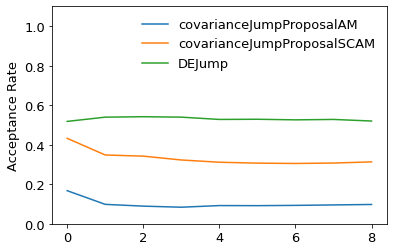

In [49]:
jumpfiles = glob.glob('./chains/chains_salt2/*jump.txt')
jumps = map(np.loadtxt, jumpfiles)
for ct, j in enumerate(jumps):
    plt.plot(j, label=jumpfiles[ct].split('/')[-1].split('_jump.txt')[0])
plt.legend(loc='best', frameon=False)
plt.ylabel('Acceptance Rate')
plt.ylim(0.0, 1.1)

In [50]:
exp3_chain = pd.read_csv("./chains/chains_exp3/chain_1.txt", sep="\s+", usecols=[0, 1, 2, 3, 4, 5, 6],names=["M", "a", "b", "om_m", "om_l", "h", "loglike"])
exp3_chain.head()

M         a         b      om_m      om_l         h      loglike
0 -21.160000  0.600000 -0.350000  0.380000  0.560000  0.700000 -7535.219992
1 -21.160232  0.624582 -0.319233  0.376387  0.559117  0.685125 -6699.106224
2 -21.165619  0.835734 -0.340298  0.386961  0.550824  0.671010 -4632.925083
3 -21.164202  0.843102 -0.353314  0.372980  0.558565  0.669664 -4487.838495
4 -21.167429  0.843257 -0.367132  0.375510  0.571765  0.663641 -4292.494633

In [51]:
salt2_chain = pd.read_csv("./chains/chains_salt2/chain_1.txt", sep="\s+", usecols=[0, 1, 2, 3, 4, 5, 6],names=["M", "a", "b", "om_m", "om_l", "h", "loglike"])
salt2_chain.head()

M         a         b      om_m      om_l         h   loglike
0 -19.100000  0.144000  2.800000  0.200000  0.500000  0.700000  0.150000
1 -19.101547  0.135487  2.802477  0.199551  0.496420  0.716544  0.153283
2 -19.095538  0.129100  2.807826  0.231789  0.505882  0.715971  0.169792
3 -19.122615  0.127793  2.816815  0.234004  0.500765  0.714129  0.176161
4 -19.128384  0.116024  2.823395  0.238834  0.501962  0.732067  0.199628

In [52]:
salt2_chain

M         a         b      om_m      om_l         h   loglike
0   -19.100000  0.144000  2.800000  0.200000  0.500000  0.700000  0.150000
1   -19.101547  0.135487  2.802477  0.199551  0.496420  0.716544  0.153283
2   -19.095538  0.129100  2.807826  0.231789  0.505882  0.715971  0.169792
3   -19.122615  0.127793  2.816815  0.234004  0.500765  0.714129  0.176161
4   -19.128384  0.116024  2.823395  0.238834  0.501962  0.732067  0.199628
..         ...       ...       ...       ...       ...       ...       ...
895 -19.699272  0.106370  2.652262  0.020250  0.140857  0.692777  0.121727
896 -19.661819  0.107535  2.681546  0.021814  0.127724  0.703864  0.126006
897 -19.576812  0.104213  2.675376  0.021815  0.163601  0.735755  0.126355
898 -19.586853  0.104550  2.654905  0.021967  0.163625  0.732876  0.125859
899 -19.564428  0.104204  2.709429  0.063901  0.220737  0.739361  0.124896

[900 rows x 7 columns]

In [53]:
histogramsN = ['M', 'a', 'b', 'Om_m', 'Om_l', 'h']
latexN  = ['M', 'alpha', 'beta', '\Omega_m', '\Omega_\Lambda', 'h']

In [54]:
chain_1 = []
for i in range(0, len(exp3_chain)):
    if i > 100:
        chain_1.append([exp3_chain["M"][i], exp3_chain["a"][i], exp3_chain["b"][i], exp3_chain["om_m"][i], exp3_chain["om_l"][i], exp3_chain["h"][i]])

In [55]:
chain_2 = []
for i in range(0, len(salt2_chain)):
    if i > 100:
        chain_2.append([salt2_chain["M"][i], salt2_chain["a"][i], salt2_chain["b"][i], salt2_chain["om_m"][i], salt2_chain["om_l"][i], salt2_chain["h"][i]])

In [56]:
chain_1 = np.array(chain_1)
chain_2 = np.array(chain_2)

In [57]:
from getdist import plots, MCSamples

In [58]:
samples_1 = MCSamples(samples=chain_1, names = histogramsN, labels = latexN)
samples_2 = MCSamples(samples=chain_2, names = histogramsN, labels = latexN)

Removed no burn in
Removed no burn in


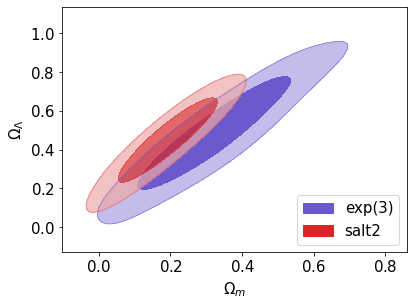

In [67]:
plt.rcParams.update({"font.size": 15})
g = plots.get_single_plotter(rc_sizes=True)

samples_1.updateSettings({'contours': [0.68, 0.95]})
samples_2.updateSettings({'contours': [0.68, 0.95]})
g.settings.alpha_filled_add = 0.7

g.settings.num_plot_contours = 2
g.plot_2d([samples_1, samples_2], 'Om_m', 'Om_l',
          filled=True,
          line_args=[{'lw':1, 'color':'slateblue'}, {'lw':2, 'color':'C3'}],
          contour_colors=['C3','slateblue'])
g.add_legend(['exp(3)', 'salt2'], legend_loc='lower right')
plt.subplots_adjust(bottom=0.15)
#plt.xlim(0, 0.8)
#plt.ylim(0, 1.2)
#plt.savefig("/home/joao/Desktop/curvas_confianca.png", dpi = 200); #g.plot_2d(samplessalt2, 'Om_m', 'Om_l');

In [60]:
np.percentile(exp3_chain['om_m'], [15.85, 50, 84.15])

array([0.20391149, 0.34017521, 0.46238256])

In [61]:
np.percentile(exp3_chain['om_l'], [15.85, 50, 84.15])

array([0.31956668, 0.50190229, 0.66044744])

In [62]:
np.percentile(exp3_chain['M'], [15.85, 50, 84.15])

array([-21.69852163, -21.14524362, -20.7356092 ])

In [63]:
np.percentile(exp3_chain['a'], [15.85, 50, 84.15])

array([0.60468322, 0.62263405, 0.64001606])

In [64]:
np.percentile(exp3_chain['b'], [15.85, 50, 84.15])

array([-0.37198456, -0.36153742, -0.35179317])